In [1]:
# Imports
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.special as sp

# Fast Fourier transform

In the following, we demonstrate a simple implementation of the FFT discussed in class. 

In [2]:
def dft(f_n):
    '''Discrete Fourier transform'''
    
    N = len(f_n)
    f_k = np.zeros((N),dtype=np.complex128)

    for k in range(N):
        for n in range(N):
            f_k[k] += f_n[n]*np.exp(-2.0*np.pi*1j*n*k/N)
        
    return f_k

def inv_dft(f_k):
    '''Inverse discrete Fourier transform'''
    
    N = len(f_k)
    f_n = np.zeros((N),dtype=np.complex128)

    for n in range(N):
        for k in range(N):
            f_n[n] += (1/float(N))*f_k[k]*np.exp(2.0*np.pi*1j*n*k/N)
        
    return f_n

def fft(f_n):
    '''Fast fourier transform'''
    N = len(f_n)
    
    if N==1:
        return f_n
    else:
        # split into even and odd and find the FFTs of each half
        f_even = f_n[0:N:2]
        f_odd = f_n[1:N:2]

        # Note the recursive function call
        F_even = fft(f_even)
        F_odd = fft(f_odd)

        # combine them.  Each half has N/2 wavenumbers, but due to 
        # periodicity, we can compute N wavenumbers
        omega = np.exp(-2*np.pi*1j/N)

        # allocate space for the frequency components
        F_k = np.zeros(N, dtype=np.complex128)
        
        for k in range(int(N/2)):
            F_k[k] = F_even[k] + omega**k * F_odd[k]
            F_k[int(N/2) + k] = F_even[k] - omega**k * F_odd[k]

    return F_k

def inv_fft(F_k):
    '''Inverse fast Fourier transform'''
    
    N = len(F_k)
    
    if N==1:
        return F_k
    else:
        # split into even and odd and find the FFTs of each half
        F_even = F_k[0:N:2]
        F_odd = F_k[1:N:2]

        f_even = inv_fft(F_even)
        f_odd = inv_fft(F_odd)

        # Each half has N/2 wavenumbers, but due to 
        # periodicity, we can compute N wavenumbers
        omega = np.exp(2*np.pi*1j/N)

        # allocate space for the frequency components
        f_n = np.zeros((N), dtype=np.complex128)
        
        # Need factor of 1/2 to multiply up to 1/2^m =1/N
        for n in range(int(N/2)):
            f_n[n] = (0.5)*(f_even[n] + omega**n * f_odd[n])
            f_n[int(N/2) + n] = (0.5)*(f_even[n] - omega**n * f_odd[n])

    return f_n

## Example: Square(ish) signal from error function

Below we compare DFT and FFT to make sure we get the same results.

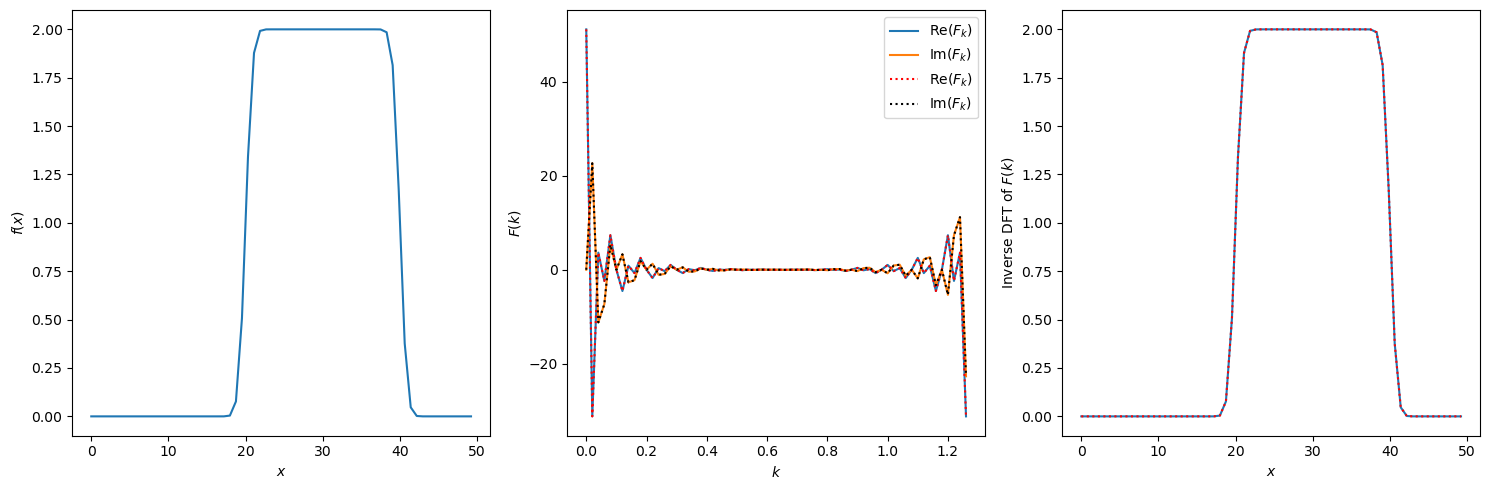

In [3]:
# Set up the function
m=6
npts=2**m
xmax=50
x=np.linspace(0.0,xmax,npts,endpoint=False)
k = np.arange(npts)/xmax
f=sp.erf(x-20)-sp.erf(x-40)

# Take the FT and inverse
Fdft=dft(f)
Ffft=fft(f)
fdft=inv_dft(Fdft)
ffft=inv_fft(Ffft)

# Plot:
fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
ax1.plot(x,f)
ax2.plot(k,np.real(Fdft),label=r"Re($F_k$)")
ax2.plot(k,np.imag(Fdft),label=r"Im($F_k$)")
ax2.plot(k,np.real(Ffft),'r:',label=r"Re($F_k$)")
ax2.plot(k,np.imag(Ffft),'k:',label=r"Im($F_k$)")

ax3.plot(x,fdft.real)
ax3.plot(x,ffft.real,'r:')

ax1.set_xlabel('$x$')
ax1.set_ylabel('$f(x)$')
ax2.set_xlabel(r'$k$')
ax2.set_ylabel('$F(k)$')
ax2.legend()

ax3.set_ylabel('Inverse DFT of $F(k)$')
ax3.set_xlabel('$x$')

fig1.tight_layout()

plt.show()

## Speed up using FFT

Now lets see how (roughly) the FFT and DFT scale with number of points.

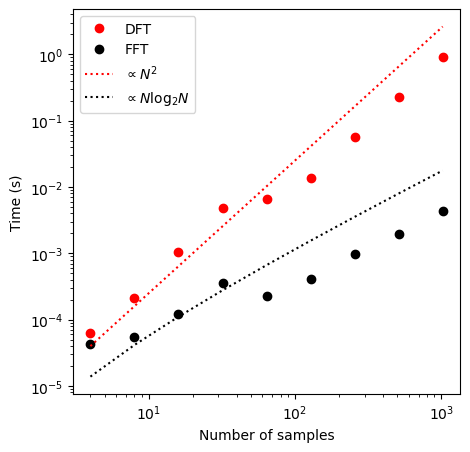

In [5]:
# Function parameters
v0=0.2
xmax=50

fft_time=[]
dft_time=[]

# Loop over sample numbers, all powers of 2
for m in range(2,11):
    npts=2**m
    x=np.linspace(0.0,xmax,npts,endpoint=False)
    f=np.sin(2*np.pi*v0*x)
    
    start = time.perf_counter()
    Fdft=dft(f)
    end = time.perf_counter()
    dft_time.append([npts,end-start])
    
    start = time.perf_counter()
    Ffft=fft(f)
    end = time.perf_counter()
    fft_time.append([npts,end-start])
    
fft_time=np.stack(fft_time)
dft_time=np.stack(dft_time)

# Plot
fig1,ax1=plt.subplots(figsize=(5,5))

ax1.plot(dft_time[:,0],dft_time[:,1],'or',label='DFT')
ax1.plot(fft_time[:,0],fft_time[:,1],'ok',label='FFT')
ax1.plot(dft_time[:,0],(dft_time[:,0]**2)*0.04*dft_time[0,1],'r:',label=r'$\propto N^2$')
ax1.plot(fft_time[:,0],(fft_time[:,0]*np.log2(fft_time[:,0]))*0.04*fft_time[0,1],'k:',label=r'$\propto N$log$_2 N$')


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Time (s)')
ax1.legend()

plt.savefig('fft_vs_dft_time.pdf',bbox_inches='tight')
plt.show()